In [3]:
from scipy.optimize import curve_fit
from sklearn import preprocessing
import networkx as nx
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
import itertools
import collections
import powerlaw
from nltk import bigrams
from nltk.util import ngrams
import os
import glob
import plotly.express as px
import plotly.graph_objs as go
from nltk.corpus import stopwords
import string
import math

In [4]:
df = pd.read_csv('df_tutti_1.csv')

In [5]:
user=[]
for i in range(0, len(df['user'])):
    c=df['user'][i].split("'")
    user.append(c[3])
    
use = np.array(user) 
unique_user = np.unique(use)
len(unique_user)

men_user=[[] for _ in range(0,len(df['mentionedUsers']))]

for i in range(0,len(df['mentionedUsers'])):
    if isinstance(df['mentionedUsers'][i],float):
        men_user[i].append('nan')
    else:
        v=df['mentionedUsers'][i].split("{")
        v.remove(v[0])
        if len(v)>1:
            for j in range(0, len(v)-1):
                d=v[j].split("'")
                men_user[i].append(d[3])
        elif len(v)==1:
            d=v[0].split("'")
            men_user[i].append(d[3])
    
    

In [6]:
df.drop(df.columns.difference(['renderedContent']), axis=1, inplace=True)

df['user']=user
df['men_user']=men_user

df['Tweet'] = df['renderedContent']
df = df.drop('renderedContent', axis=1)

# remove words that start with '@'
df['Tweet'] = df['Tweet'].str.replace(r'@\w+', '', regex=True)

In [7]:
len(df['user'].unique())


22102

Creating a directed and weighted graph

In [8]:
# Create empty directed graph
g = nx.DiGraph()

# Iterate through rows of dataframe
for _, row in df.iterrows():
    user = row['user']
    men_users = row['men_user']
    tweet = row['Tweet']
    
    # Add nodes to graph if they don't already exist
    if not g.has_node(user):
        g.add_node(user)
    
    for pair in itertools.combinations(men_users, 2):
        if not g.has_edge(*pair):
            # If edge does not exist, add with weight 1 and tweet attribute
            g.add_edge(*pair, weight=1, tweet=[tweet])
        else:
            # If edge already exists, increment weight by 1 and append tweet attribute
            g.edges[pair]['weight'] += 1
            g.edges[pair]['tweet'].append(tweet)

# g_dir.remove_edges_from(nx.selfloop_edges(g_dir))            

Create empty undirected graph

In [9]:
# Create empty undirected graph
G = nx.Graph()

# Iterate through rows of dataframe
for _, row in df.iterrows():
    user = row['user']
    men_users = row['men_user']
    tweet = row['Tweet']
    
    # Add nodes to graph if they don't already exist
    G.add_node(user)
    for men_user in men_users:
        G.add_node(men_user)
        # Add undirected edge with tweet attribute
        G.add_edge(user, men_user, tweet=[tweet])
          

In [10]:
# Get list of edges sorted by weight in descending order
edges_sorted = sorted(g.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Print top 10 heaviest edges with their weights and tweets
for edge in edges_sorted[:10]:
    print(edge[:2], edge[2]['weight'])


('CarloCalenda', 'Azione_it') 339
('ItaliaViva', 'Azione_it') 244
('mara_carfagna', 'Azione_it') 233
('Azione_it', 'CarloCalenda') 202
('FratellidItalia', 'GiorgiaMeloni') 193
('CarloCalenda', 'matteorenzi') 187
('Filippo_Rossi', 'CarloCalenda') 177
('Azione_it', 'ItaliaViva') 176
('meb', 'ItaliaViva') 171
('matteorenzi', 'ItaliaViva') 167


C:\Users\Giova\AppData\Local\Temp\ipykernel_10436\2489524616.py:15: RuntimeWarning: divide by zero encountered in log
  y = np.log(hist)


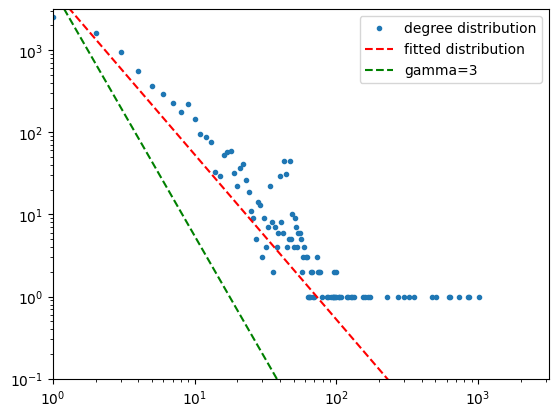

Gamma=2.008824306225437


In [15]:
k = nx.degree_histogram(g)
sig=np.array(k[1:])


# define the function to fit
def expfunc(x, a , b):
    return a*pow(x,-b)

# bin the degree distribution
bins = np.arange(len(k))
hist = nx.degree_histogram(g)

# fit the logarithm of the degree distribution to a linear function
x = bins[1:]
y = np.log(hist)

popt, pcov = curve_fit(expfunc, x, k[1:], sigma=(sig/1)+2, absolute_sigma=True)

# plot the degree distribution and the fitted distribution on a logarithmic scale
plt.plot(range(0, len(hist)), hist,'.',label='degree distribution')
plt.plot(x, expfunc(x, *popt), 'r--', label='fitted distribution')
plt.plot(x, expfunc(x, popt[0], 3.0), 'g--', label='gamma=3')
plt.legend()
plt.ylim( (10**-1,10**3.5) )
plt.xlim( (10**0,10**3.5) )
plt.xscale('log')
plt.yscale('log')
plt.show()

# print the estimated value of b
print(f"Gamma={popt[1]}")

C:\Users\Giova\AppData\Local\Temp\ipykernel_10436\718644843.py:15: RuntimeWarning: divide by zero encountered in log
  y = np.log(hist)


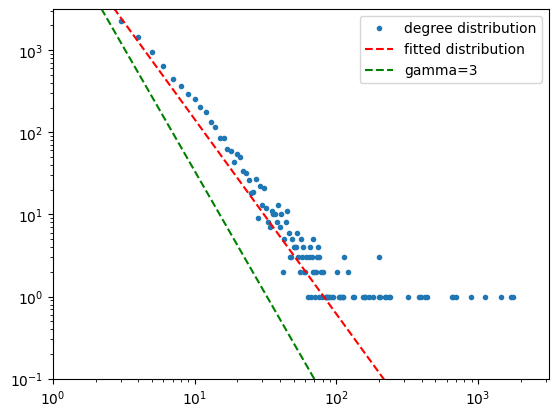

Gamma=2.3710289613874678


In [16]:
k = nx.degree_histogram(G)
sig=np.array(k[1:])


# define the function to fit
def expfunc(x, a , b):
    return a*pow(x,-b)

# bin the degree distribution
bins = np.arange(len(k))
hist = nx.degree_histogram(G)

# fit the logarithm of the degree distribution to a linear function
x = bins[1:]
y = np.log(hist)

popt, pcov = curve_fit(expfunc, x, k[1:], sigma=(sig/1)+2, absolute_sigma=True)

# plot the degree distribution and the fitted distribution on a logarithmic scale
plt.plot(range(0, len(hist)), hist,'.',label='degree distribution')
plt.plot(x, expfunc(x, *popt), 'r--', label='fitted distribution')
plt.plot(x, expfunc(x, popt[0], 3.0), 'g--', label='gamma=3')
plt.legend()
plt.ylim( (10**-1,10**3.5) )
plt.xlim( (10**0,10**3.5) )
plt.xscale('log')
plt.yscale('log')
plt.show()

# print the estimated value of b
print(f"Gamma={popt[1]}")

In [14]:
def net_basic_info(g):
    nodes = g.number_of_nodes()
    edges = g.number_of_edges()
    directness = g.is_directed()
    self_loops = nx.number_of_selfloops(g)
    lMax = ((nodes) * (nodes - 1)) / 2
    AvgDegree = sum(dict(g.degree()).values())/float(len(g))

    print('- Numero Nodi:', nodes)
    print('- Numero Edges:', edges)
    print ("- Numero di self-loop: ", self_loops)
    print("- La rete e' diretta:",directness)
    print('- Numero massimo di collegamenti (L_max):', lMax)
    print('- Avarage Degree:', AvgDegree)

In [15]:
net_basic_info(G)

- Numero Nodi: 30532
- Numero Edges: 57221
- Numero di self-loop:  17
- La rete e' diretta: False
- Numero massimo di collegamenti (L_max): 466086246.0
- Avarage Degree: 3.748264116336958


In [16]:

# Definisco le caratteristiche del grafo reale
n_nodi = 30532
n_edges = 57221
n_self_loops = 17

# Average degree
avg_degree=(2*n_edges)/n_nodi



Creazione i quattro modelli sintetici di reti

In [20]:
p = avg_degree/(2*(n_nodi-1))
p

6.13845618606819e-05

In [21]:
# Erdos Renyi model
er = nx.erdos_renyi_graph(n_nodi, p = avg_degree/(2*(n_nodi-1)), directed=True, seed = 42)
er.number_of_edges()



57130

In [22]:
# check if p is greater tham 1/n_nodes
p = avg_degree/((2)*(n_nodi-1))
pc = (1/n_nodi)
p > pc

True

In [23]:
# Barabasi Albert model
ba = nx.barabasi_albert_graph(n_nodi, 2)
ba.number_of_edges()

61060

In [24]:
# n_edges//n_nodi = 1, ma ho messo 2

In [25]:
# Watts Strogatz model; k and p are chosen so that the number of links is similar to the rw network
ws = nx.watts_strogatz_graph(n_nodi, k = 4, p = 0.01, seed = 34)
ws.number_of_edges()

61064

In [26]:
# Configuration model
# fitting the degree distribution of the real graph
sequence = [i[1] for i in G.degree()]

cm = nx.configuration_model(sequence)
cm.number_of_edges()


57221

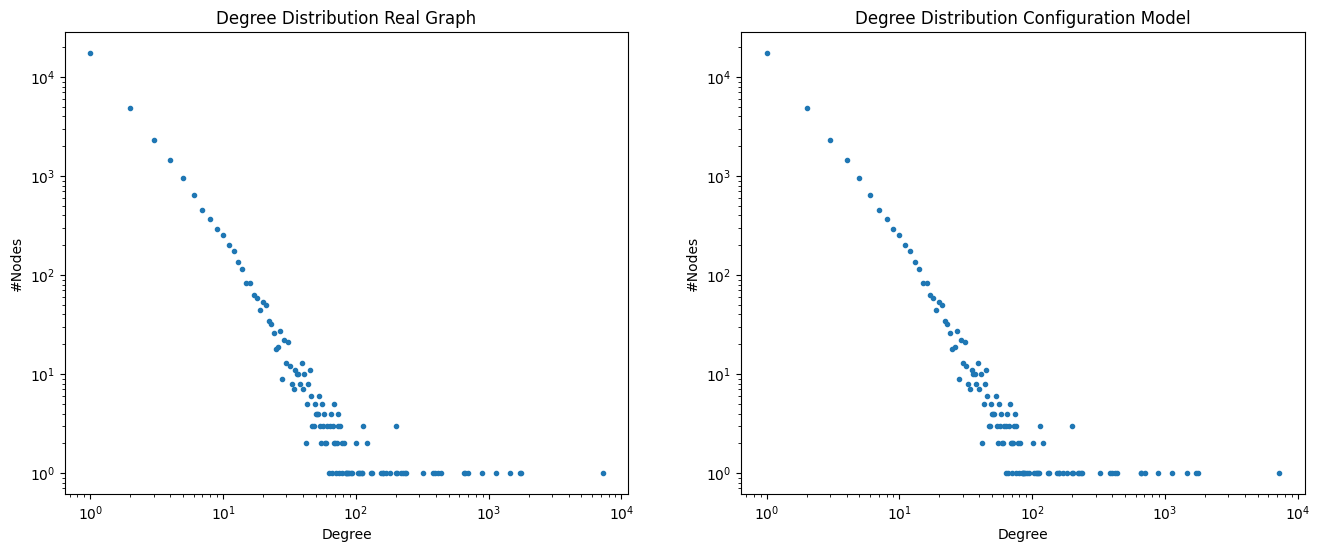

In [27]:
hist_o = nx.degree_histogram(G)
hist = nx.degree_histogram(cm)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_o)), hist_o, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Configuration Model")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [28]:
network_list = [ws, er, ba]
network_names = ["Watts Strogats", "Erdos-Renyi", "Barabasi Albert"]

In [29]:
def find_hubs(G, degree_threshold):
    '''Function for extracting hubs and not hubs from the network'''
    hubs = []
    notHubs = []
    for i in G:
        if G.degree(i) >= degree_threshold:
            hubs.append(i)
        else:
            notHubs.append(i)
    print(len(hubs))
    return hubs, notHubs

In [30]:
find_hubs(G, 10)

1813


(['giuno55',
  'pdnetwork',
  'nan',
  'MarcoTastardi',
  'emmabonino',
  'CottarelliCPI',
  'Piu_Europa',
  'DavideR46325615',
  'bendellavedova',
  'riccardomagi',
  'EnricoLetta',
  'Illungimirante',
  'VittorioBanti',
  'europaverde_it',
  'GiZollino',
  'Pierluigibac',
  'itinagli',
  'peppeprovenzano',
  'Deputatipd',
  'SenatoriPD',
  'VCuppi',
  '62_rocco',
  'RaffaeleGianni4',
  'Ernesto040989',
  'spighissimo',
  'cavalierebianc5',
  'albertocallerio',
  'massive_italy',
  'rudi_lunardi',
  'UnioneCivicaVi',
  'ComVentotene',
  'drndbl',
  'giodiamanti',
  'Zizouzidane77',
  'MarcoFattorini',
  'angelo_falanga',
  'BeppeGatti',
  'sbonaccini',
  'bravimabasta',
  'elide_muccioli',
  'Sofiajeanne',
  'IpensieriA',
  'FPanunzi',
  'rivamatteoriva',
  'Agenzia_Ansa',
  'ilFalconiereII',
  'GiuseppeConteIT',
  'AbracaBarna',
  'micheledammicc1',
  'Nalu_2017',
  'ACmcoppola',
  'PBerizzi',
  'Delpinsky21',
  'LiciaRonzulli',
  'Corriere',
  'pisto_gol',
  'alanfriedmanit',
  'sal

In [51]:
from networkx.drawing.nx_agraph import graphviz_layout

# Plot grafo generico
def plot_graph(G):
    nx.draw(G, with_labels = True)  
    plt.show()

# Plot grafo pesato
def plot_graph_with_weights(G):
    pos = nx.planar_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw_networkx(G,pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

In [45]:

comps = list(nx.connected_components(G))
print("Number of connected components (RW): ", len(comps))

er = er.to_undirected()
comps = list(nx.connected_components(er))
print("Number of Connected Components (ER): ", len(comps))


comps = list(nx.connected_components(ws))
print("Number of Connected Components (WS): ", len(comps))


comps = list(nx.connected_components(ba))
print("Number of Connected Components (BA): ", len(comps))


comps = list(nx.connected_components(cm))
print("Number of Connected Components (CM): ", len(comps))

Number of connected components (RW):  1413
Number of Connected Components (ER):  712
Number of Connected Components (WS):  1
Number of Connected Components (BA):  1
Number of Connected Components (CM):  1473


In [53]:
# Grafo di una delle componenti connesse presenti
H = nx.Graph()
H = nx.subgraph(G,comps[0]) 

In [36]:
print('Number weakly connected components (RW): ', str(nx.number_weakly_connected_components(g)))
print('Number strongly connected components (RW): ', str(nx.number_strongly_connected_components(g)))

Number weakly connected components (RW):  19501
Number strongly connected components (RW):  25371


In [11]:
def clust_coeff_density_info(G):
    print("Average clustering coeff: ", nx.average_clustering(G))
    print("Density': ", nx.density(G))

In [12]:
clust_coeff_density_info(G)

Average clustering coeff:  0.050058478637297114
Density':  0.0001227691237213638


In [31]:
for net, net_name in zip(network_list, network_names):
    print(f"\nModel: {net_name}\n----------------------------")
    clust_coeff_density_info(net)




Model: Watts Strogats
----------------------------
Average clustering coeff:  0.0
Density':  6.550718941403819e-05

Model: Erdos-Renyi
----------------------------
Average clustering coeff:  5.296290750895754e-05
Density':  6.128694044320715e-05

Model: Barabasi Albert
----------------------------
Average clustering coeff:  0.0
Density':  6.550504388837941e-05


In [44]:
def draw_top_n(dictionary, n):
    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:n]
    x, y = zip(*sorted_items)
    plt.figure(figsize=(20,5))
    plt.bar(x, y, color='b')
    plt.xticks(rotation=45)
    plt.show()


Path analysis

In [40]:
comps = list(nx.connected_components(G))
print("Number of Connected Components (G): ", len(comps))

print("Diameter (G) :", nx.diameter(G.subgraph(comps[1])))
print("Average shortest path (G):", nx.average_shortest_path_length(G.subgraph(comps[0])))
print("Average shortest path weighted (G):", nx.average_shortest_path_length(g.subgraph(comps[0]), weight='weight'))

Number of Connected Components (G):  1413
Diameter (G) : 1


KeyboardInterrupt: 

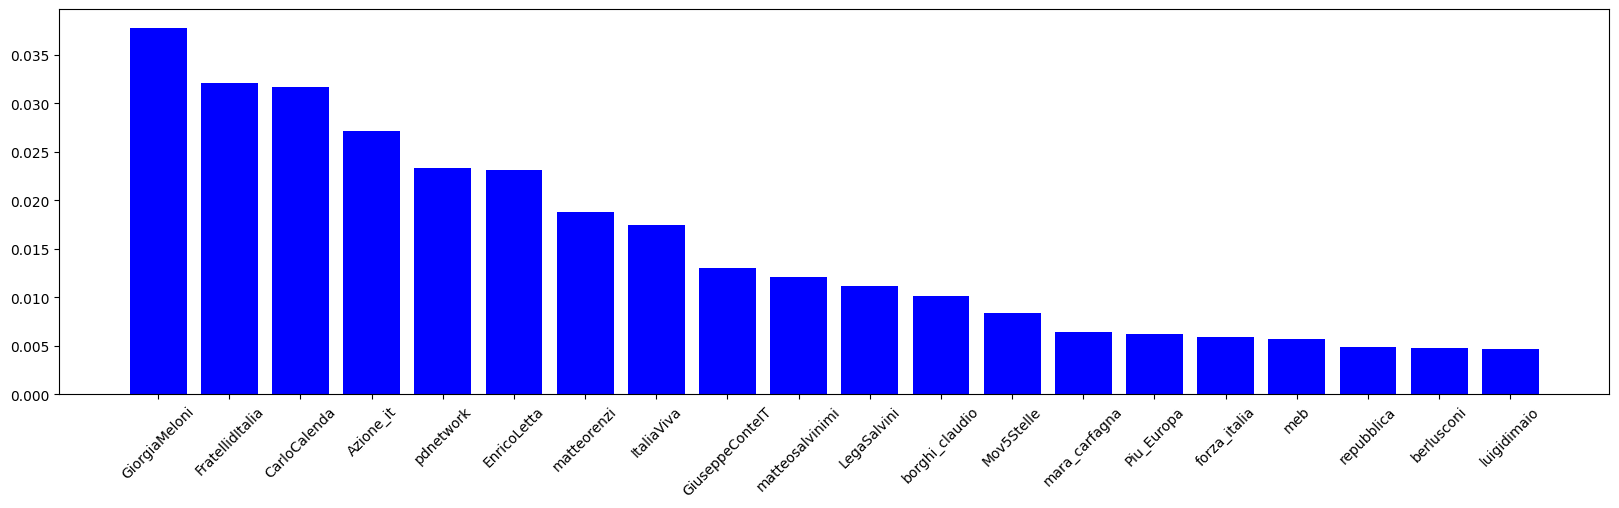

In [49]:
# Degree Centrality
degree_centrality = nx.degree_centrality(g)
draw_top_n(degree_centrality, 20)

In [50]:
comps = list(nx.connected_components(er))
print("Number of Connected Components (ER): ", len(comps))

print("Diameter (ER) :", nx.diameter(er.subgraph(comps[0])))
print("Average shortest path (ER):", nx.average_shortest_path_length(er.subgraph(comps[0])))

Number of Connected Components (ER):  712


KeyboardInterrupt: 

In [ ]:
comps = list(nx.connected_components(ws))
print("Number of Connected Components (WS): ", len(comps))

print("Diameter (WS) :", nx.diameter(ws.subgraph(comps[0])))
print("Average shortest path (WS):", nx.average_shortest_path_length(ws.subgraph(comps[0])))

Number of Connected Components (WS):  1


KeyboardInterrupt: 

In [37]:
comps = list(nx.connected_components(ba))
print("Number of Connected Components (BA): ", len(comps))

Number of Connected Components (BA):  1


In [ ]:
comps = list(nx.connected_components(cm))
print("Number of Connected Components (CM): ", len(comps))

print("Diameter (CM) :", nx.diameter(ba.subgraph(comps[0])))
print("Average shortest path (CM):", nx.average_shortest_path_length(ba.subgraph(comps[0])))

In [ ]:
for net, net_name in zip(network_list, network_names):
    print(f"\nModel: {net_name}\n----------------------------")
    print("Average clustering:", nx.average_clustering(net))
    print("Density (BA) :", nx.density(net))

TypeError: float() argument must be a string or a number, not 'dict'

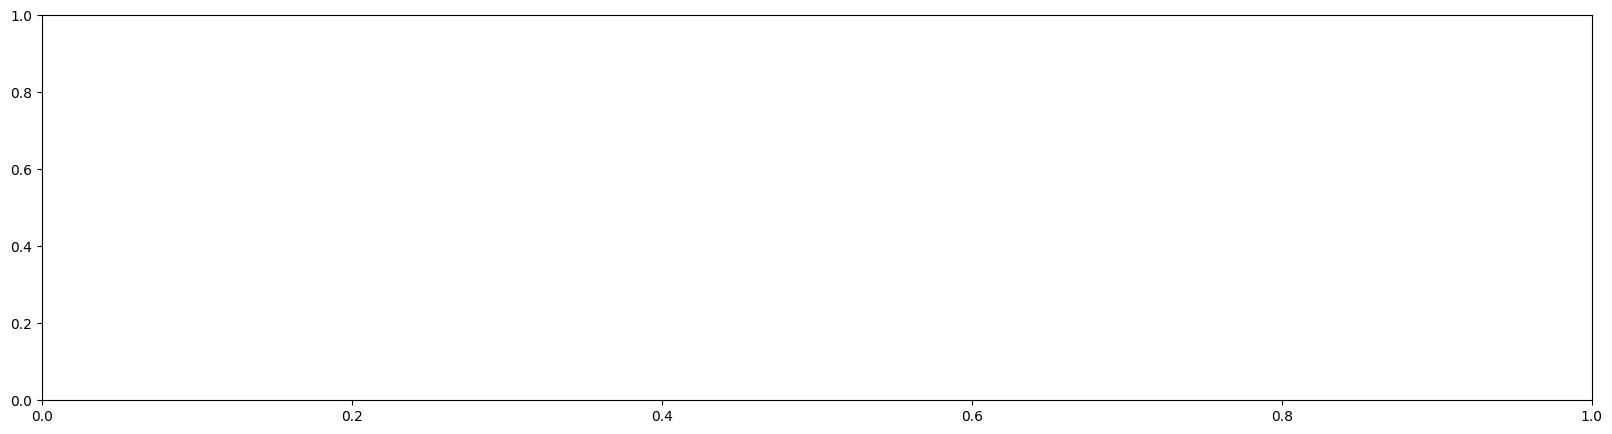

In [40]:
degrees = G.degree()

y = []
x = []

for degree in degrees:
    node = degree[0]
    degree = degree[1]
    local_clustering_coefficient = nx.clustering(g,node)
    
    y.append(local_clustering_coefficient)
    x.append(degree)

    
plt.figure(figsize=(20,5))
plt.scatter(x, y)

plt.xlabel("k")
plt.ylabel("C(k)")

plt.show()


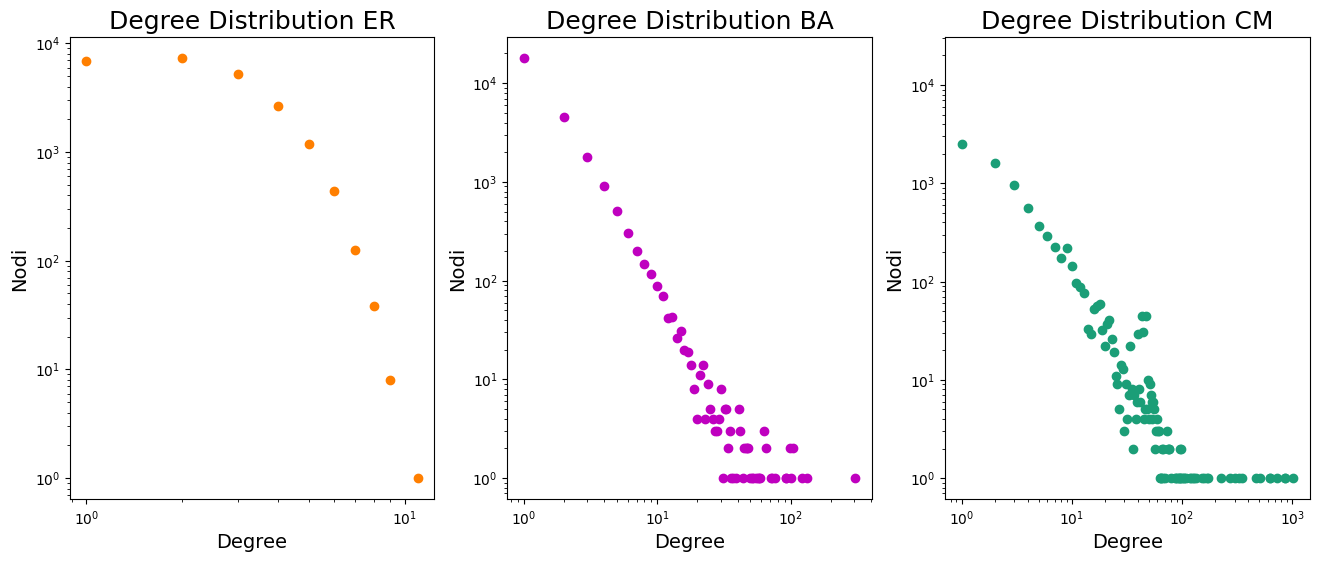

In [ ]:
hist_g = nx.degree_histogram(G)
hist_er = nx.degree_histogram(er)
hist_ba = nx.degree_histogram(ba)
# hist_ws = nx.degree_histogram(ws)
hist_cm = nx.degree_histogram(cm)

fig = plt.figure(figsize=(16, 6)) 


plt.subplot(1, 3, 1)
plt.plot(range(0, len(hist_er)), hist_er,  "o", color = '#ff7f00')
plt.title("Degree Distribution ER", fontsize = 18)
plt.xlabel("Degree", fontsize = 14)
plt.ylabel("Nodi", fontsize = 14)
plt.loglog()

plt.subplot(1, 3, 2)
plt.plot(range(0, len(hist_ba)), hist_ba, "o", color = 'm')
plt.title("Degree Distribution BA", fontsize = 18)
plt.xlabel("Degree", fontsize = 14)
plt.ylabel("Nodi", fontsize = 14)
plt.loglog()

plt.subplot(1, 3, 3)
plt.plot(range(0, len(hist_cm)), hist_cm, "o", color = '#1b9e77')
plt.title("Degree Distribution CM", fontsize = 18)
plt.xlabel("Degree", fontsize = 14)
plt.ylabel("Nodi", fontsize = 14)
plt.loglog()


plt.savefig('degree_dist_mod_sintetici_er_ba_cm.png')
plt.show()

Centrality Analysis

In [41]:
# Connectivity Based Centrality
eigenvector_centrality = nx.eigenvector_centrality(g, weight='weight', max_iter=1000)
draw_top_n(eigenvector_centrality, 20)

NameError: name 'draw_top_n' is not defined

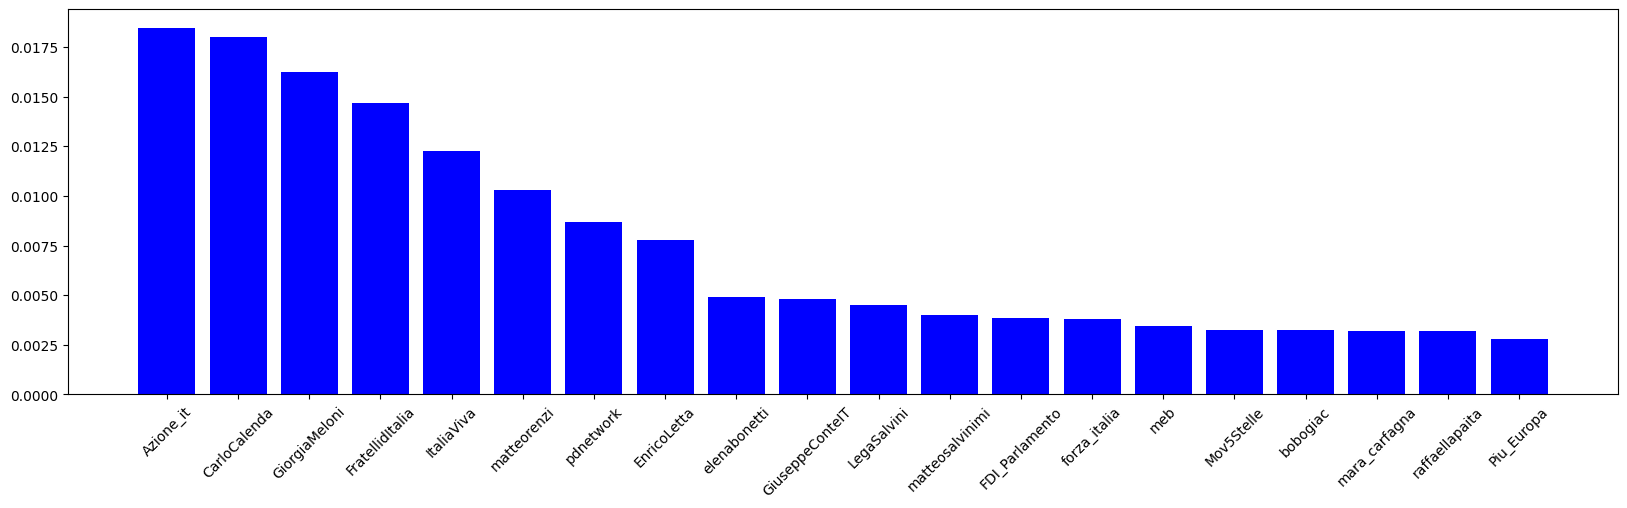

In [44]:
# Pagerank centraility
pagerank_centrality = nx.pagerank(g, weight='weight')
draw_top_n(pagerank_centrality, 20)

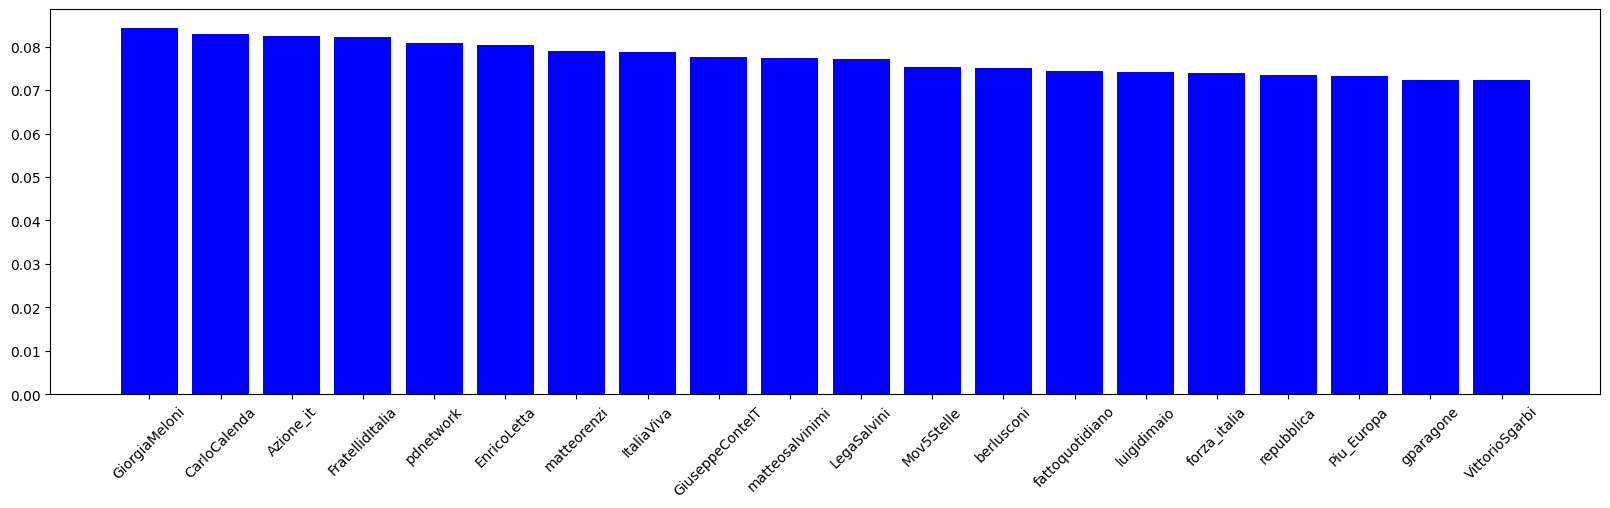

In [45]:
closeness_centrality = nx.closeness_centrality(g)
draw_top_n(closeness_centrality, 20)

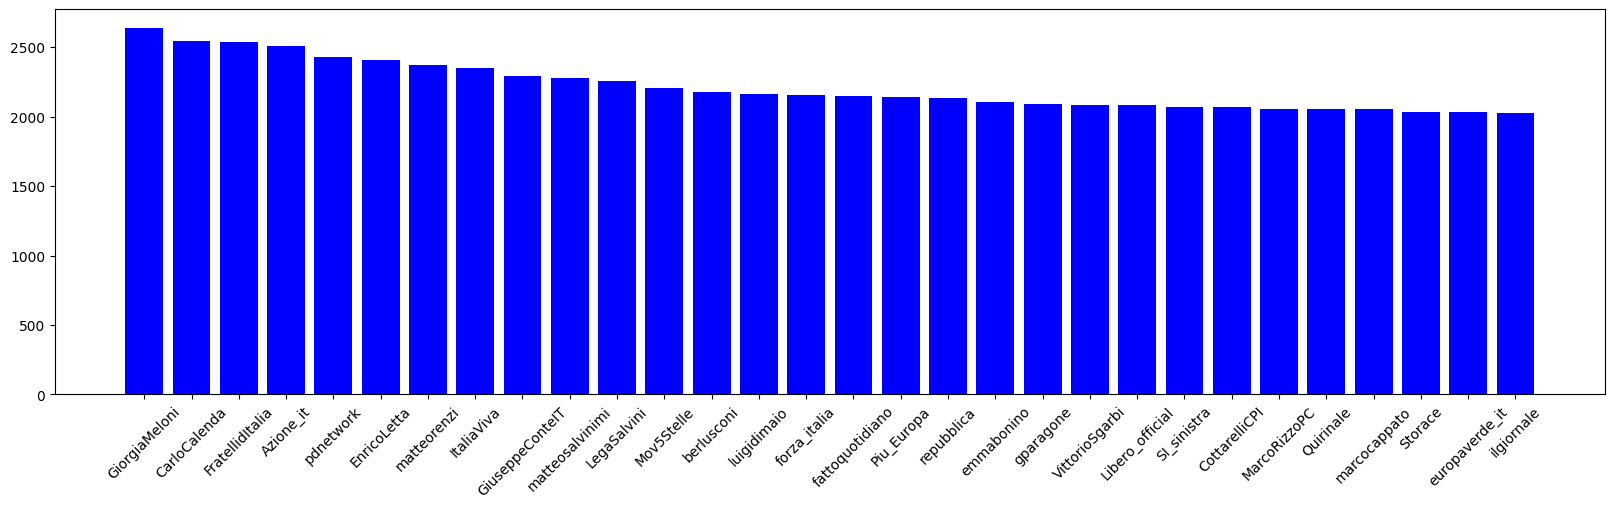

In [46]:
harmonic_centrality = nx.harmonic_centrality(g)
draw_top_n(harmonic_centrality, 30)

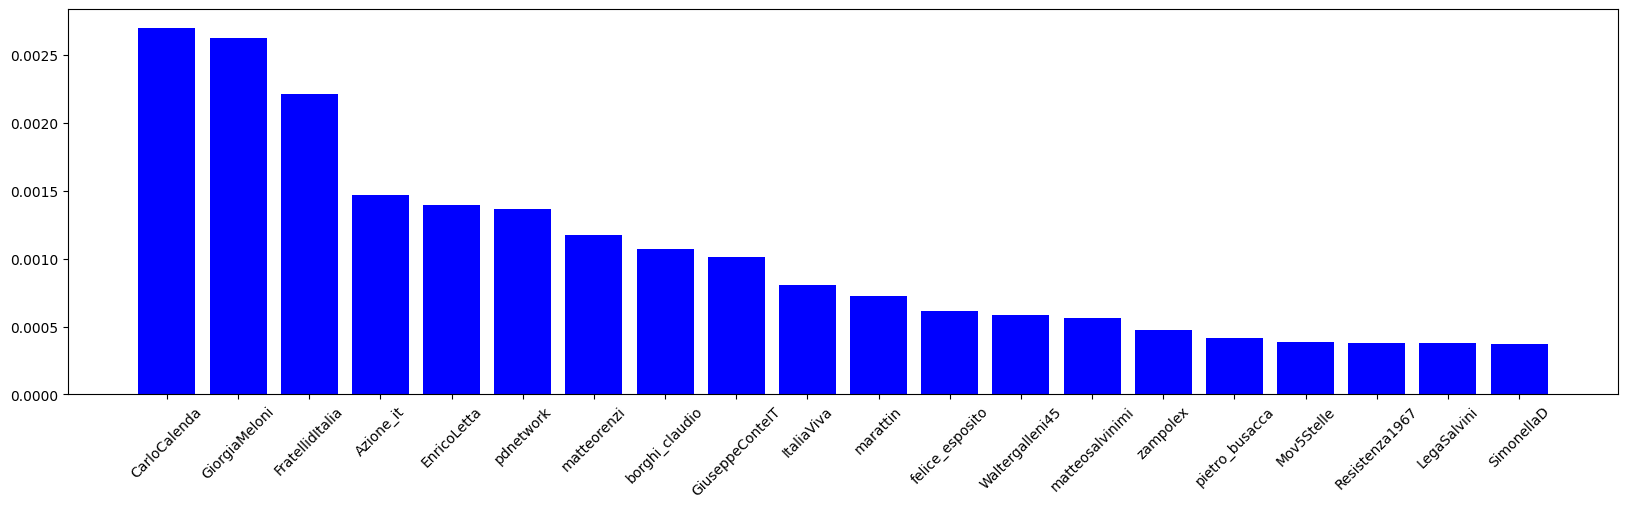

In [47]:
# too much time
betweenness_centrality = nx.betweenness_centrality(g, weight='weight')
draw_top_n(betweenness_centrality, 20)

In [48]:
print("----------------------------------\n CLUSTERING COFFICIENT E DENSITA \n----------------------------------\n")
print("RETE REALE")
print ("- Densita':", nx.density(g),
       "\n - Average Clustering Coeff: ", nx.average_clustering(g)) 
print("\nMODELLO ER")
print ("- Densita':", nx.density(er),
       "\n - Average Clustering Coeff: ", nx.average_clustering(er))
print("\nMODELLO BA")
print ("- Densita':", nx.density(ba),
       "\n - Average Clustering Coeff: ", nx.average_clustering(ba))
print("\nMODELLO WS")
print ("- Densita':", nx.density(ws),
       "\n- Average Clustering Coeff: ", nx.average_clustering(ws))
print("\n CONFIGURATION MODEL")
cm2 = nx.Graph(cm)
print ("- Densita':", nx.density(cm),
       "\n- Average Clustering Coeff: ", nx.average_clustering(cm2))

----------------------------------
 CLUSTERING COFFICIENT E DENSITA 
----------------------------------

RETE REALE
- Densita': 3.993345926793763e-05 
 - Average Clustering Coeff:  0.09316567264292744

MODELLO ER
- Densita': 6.128694044320715e-05 
 - Average Clustering Coeff:  5.296290750895754e-05

MODELLO BA
- Densita': 0.00013100579672544125 
 - Average Clustering Coeff:  0.0025057498848362926

MODELLO WS
- Densita': 0.00013101437882807637 
- Average Clustering Coeff:  0.4875529499104772

 CONFIGURATION MODEL
- Densita': 0.0001227691237213638 
- Average Clustering Coeff:  0.03405978663444805
